# timeframe: 2011-02-21 to 2018-09-09

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import spacy
from textblob import TextBlob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import words
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, MWETokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, MeanShift

from sklearn import metrics

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import joblib
pd.options.display.colheader_justify = 'right'
pd.options.display.column_space = 1
pd.options.display.expand_frame_repr = True
pd.options.display.max_colwidth = 120

In [2]:
df = joblib.load('data/clean/clean_df.joblib')
df = df.loc[df.body != 'full quote', :] # drop the 'full quote' only comment

In [3]:
# don't use stemming with Word2Vec

In [4]:
df.shape

(45671, 10)

In [18]:
df.head(3)

,body,score,author,permalink,comment_id,created_loc,created_utc,post_title,post_score,post_id
0,that's an odd hashtag to throw at the end of this tweet,1085,RajasConCrema,/r/nba/comments/65wmkz/withers_lebron_said_he_couldnt_imagine_losing_a/dgdq1yr/,dgdq1yr,2017-04-18 00:37:33,2017-04-17 16:37:33,"[Withers] LeBron said he couldn't imagine losing a sibling like Isaiah Thomas did. ""I can only imagine how that woul...",1398,65wmkz
1,that situation is so tough already i can't imagine what it is like preparing all season to get ready for the playoff...,84,NaN,/r/nba/comments/65wmkz/withers_lebron_said_he_couldnt_imagine_losing_a/dgdpz3b/,dgdpz3b,2017-04-18 00:36:07,2017-04-17 16:36:07,"[Withers] LeBron said he couldn't imagine losing a sibling like Isaiah Thomas did. ""I can only imagine how that woul...",1398,65wmkz
2,i don't think it's brought up enough that he never had a sibling or a father figure the fact that he's a great team ...,209,writingandshit,/r/nba/comments/65wmkz/withers_lebron_said_he_couldnt_imagine_losing_a/dgdsthu/,dgdsthu,2017-04-18 01:28:48,2017-04-17 17:28:48,"[Withers] LeBron said he couldn't imagine losing a sibling like Isaiah Thomas did. ""I can only imagine how that woul...",1398,65wmkz


In [61]:
# TODO: Properly do entire data set and a train_test_split later on
df_small = df[:30000]

df_small_train = df_small[:int(0.7 * df_small.shape[0])]
df_small_test = df_small[int(0.7 * df_small.shape[0]):]

# TF

### Next steps:
1. I want to find the X topics/clusters about these texts. Perhaps it's fitness, politics, training, performance, GOAT.
2. Figure out which topic each document best corresponds to, and place the document within that topic/cluster
3. Chart a stacked-bar or a multi-line chart for each year (or month, or something else) from 2011-2018, and show
   the PERCENTAGE (Or COUNT) of each topic for that period of time.
4. Look at the insights! What does that mean?
5. Perhaps do sentiment analysis. See if I can find a well-trained model. Or train my own based on upvote? score? (Probably not doing this)

**NOTE**: Simply do LDA first, and make this work. Get a chart. Get some insights.
**THEN:** Make it repeatable. Get it in a function somehow. Try other Dim Red and Unclassifying and Topic modeling techniques. See what works best.

In [5]:
def see_lda_topics(vectorizer, n_topics, fit_lda, n_examples):
    '''
    Prints top 10 names assigned to the topics, and the topics themselves
    '''
    vocab = vectorizer.get_feature_names()
    for topic in range(n_topics):
        print(f"TOPIC {topic}")
        for j in np.argsort(-fit_lda.components_,1)[topic,:n_examples]:
            print(vocab[j])
        print()

In [3]:
words_corpus = set(words.words())
analyzer = CountVectorizer().build_analyzer()
stem = SnowballStemmer('english')

stops = stopwords.words('english')
stops += ['lebron', 'james', 'game',
          'gon', 'gonna', 'na', 'ca', 'really'
          'just', 'lol', 'like', 'im', 'he', 'hes', 'would', 'get', 'going',
          'doesnt', 'th', 'fuck', 'think', 'even', 'dont', 'even',
          'didnt', 'cant', 'say', 'see', 'look', 'go', 'said', 'also',
         ]
stops = set(stops)
acceptable_words = words_corpus - stops

In [4]:
# create a custom vectorizer class that inherits from base class
# add a few more custom preprocessing and tokenization steps
class CustomVectorizer(CountVectorizer):  
    def build_analyzer(self):
        stop_words = stops
        
        def analyzer(doc):
            
            # preprocess: do any further cleaning here if needed
            # example: remove everything but letters
#             cleaned_doc = re.sub(r"[^A-Za-z]", " ", doc)
            cleaned_doc = doc
    
            # instantiate snowball stemmer
            stemmer = SnowballStemmer("english")
            # create tokens
            tokens = [stemmer.stem(d) for d in word_tokenize(cleaned_doc) if d in acceptable_words] 
            
            # multi-word expression tokenizer
            tokenizer = MWETokenizer()
            tokenizer.add_mwe(('k', 'love'))
            tokenizer.add_mwe(('kevin', 'love'))
            tokenizer.add_mwe(('dwayne', 'wade'))
            tokenizer.add_mwe(('d', 'wade'))
            tokenizer.add_mwe(('jr', 'smith'))
            tokenizer.add_mwe(('j', 'r', 'smith'))
            tokenizer.add_mwe(('j', 'r'))
            # tokenize the tokens
            tokens = tokenizer.tokenize(tokens)
            
            return(self._word_ngrams(tokens, stop_words))
        return analyzer

In [ ]:
def english_corpus(doc, stemmer=stem):
    clean_words = [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]   
    return [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]

Current isues:
* can't use stemmer and n_grams at same time.
* still too many junk words, even with growing stop_list
* **don't have a lemmatizer in there. How can i do lemmatize, n_grams, stop words, and stemmer all in analyer?**

In [72]:
# BI GRAMS

In [72]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.70,
                               min_df=3,
                               stop_words = stops,
                               ngram_range=(2,2)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df_small_train.body)
#dtm_tf_custom.shape

for n_topic in range(6,12):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 10)

:::::
Number of topics = 6
:::::
TOPIC 0
locker room
last night
never seen
dan gilbert
social media
good basketbal
know one
wide open
banana boat
basketbal player

TOPIC 1
last year
best player
player leagu
anyon els
next year
player ever
free throw
god damn
eastern confer
make sure

TOPIC 2
year old
everi time
pretti good
pretti much
pretti sure
high school
free agenc
cap space
pretti cool
st team

TOPIC 3
got ta
come back
last season
one best
last time
top time
first round
new york
pat riley
jimmi butler

TOPIC 4
regular season
first time
golden state
next season
one day
win championship
career high
feel bad
good thing
everi team

TOPIC 5
best player
tripl doubl
ever seen
space jam
realli good
much better
larri bird
win team
player team
jump shot

:::::
Number of topics = 7
:::::
TOPIC 0
last night
locker room
wide open
dan gilbert
good basketbal
last two
never seen
know one
good thing
one land

TOPIC 1
last year
next year
player ever
god damn
much better
basketbal player
pretti good

In [77]:
# MOSTLY UNI GRAMS. ALLOWS BI AND TRI GRAMS

In [77]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.5,
                               min_df=3,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df_small.body)
#dtm_tf_custom.shape

for n_topic in range(6,16):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 10)

:::::
Number of topics = 6
:::::
TOPIC 0
peopl
got
know
realli
back
love
first
better
pretti
thought

TOPIC 1
year
realli
wade
last
time
pretti
good
score
one
sure

TOPIC 2
team
player
best
leagu
one
great
top
ever
everi
play

TOPIC 3
time
come
man
right
one
day
could
back
guy
watch

TOPIC 4
play
love
ball
way
time
jordan
high
one
still
point

TOPIC 5
season
win
team
one
good
much
heat
first
anyon
damn

:::::
Number of topics = 7
:::::
TOPIC 0
got
peopl
know
realli
back
better
thought
good
want
pretti

TOPIC 1
year
realli
wade
time
old
bosh
pretti
last
next
one

TOPIC 2
team
player
best
leagu
top
one
everi
ever
year
play

TOPIC 3
come
man
time
could
day
one
back
right
watch
make

TOPIC 4
play
love
ball
way
one
time
jordan
still
better
point

TOPIC 5
season
team
win
one
good
first
heat
much
doubl
need

TOPIC 6
time
great
last
best
still
peopl
well
one
season
end

:::::
Number of topics = 8
:::::
TOPIC 0
peopl
know
got
back
thought
realli
better
hate
someth
video

TOPIC 1
year
wade
reall

In [76]:
# TRI-GRAMS

In [76]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.5,
                               min_df=3,
                               stop_words = stops,
                               ngram_range=(3,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df_small.body)
#dtm_tf_custom.shape

for n_topic in range(3,9):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 10)

:::::
Number of topics = 6
:::::
TOPIC 0
best player team
one best ever
best basketbal player
team st team
basketbal player ever
time score list
best team leagu
guy pretti good
time last year
lose first round

TOPIC 1
free throw line
player ever play
got ta give
name icon duo
best point guard
realli realli good
actual pretti good
field goal percentag
take south beach
provid basketbal refer

TOPIC 2
top player time
man know one
one best leagu
know one land
best team ever
point tripl doubl
good basketbal player
year old year
top player ever
old year old

TOPIC 3
best player world
tweet video mirror
video mirror send
temporarili unavail around
day feedback send
back within day
mirror send convers
convers temporarili unavail
unavail around fix
fix back within

TOPIC 4
still best player
last year year
regard human life
great role model
got ta love
one best time
free throw shoot
best player planet
sinc rooki year
banana boat crew

TOPIC 5
best player leagu
averag tripl doubl
second best play

In [5]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.7,
                               min_df=3,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df.body)
#dtm_tf_custom.shape

loop_lda_tf = LatentDirichletAllocation(n_components=5, random_state=0, n_jobs=-1)
#loop_lda_tf.fit(dtm_tf_custom)

transformed_lda = loop_lda_tf.fit_transform(dtm_tf_custom)

In [136]:
print(transformed_lda[0])
print(transformed_lda[10])

[0.83455617 0.04276683 0.0407684  0.04119354 0.04071506]
[0.83715925 0.04088751 0.04095007 0.04057556 0.04042761]


In [113]:
transformed_lda.shape

(45671, 5)

In [202]:
# cossim = cosine_similarity(transformed_lda[:1000]) USE THIS ONE
#eucdist = euclidean_distances(transformed_lda[:20000])

In [200]:
# # generate cosine_similarity and euclidian distance scores. They seem quite similar. For now i'll choose cosine similarity
# print(df.body.iloc[6])
# print(df.body.iloc[7])
# print(cossim[6,7])
# print(eucdist[6,7])

# Use Clustering Algo to group documents into X num_topics by most similar topics

In [ ]:
# PICK A CLUSTERING ALGO THAT USES COSINE SIMILARITY
### PERHAPS DBSCAN
##### create clusters (start with a small number, clusters DOES NOT need to equal the number of topics)

#----------- Chad recommended this:
# plot by argmax (basically saying which topic is most dominant in each document)
# plot by a groupby(time) and then mean the values of each topic. so then i'll have "documents for jan 2011 have [t1, t2, t3, t4, t5] and plot that.
# look into a hard clusting like Kmeans (right now, let's put this behind us)

In [ ]:
ag = AgglomerativeClustering(n_clusters=2, affinity='cosine'

In [6]:
db = None
db = DBSCAN(eps=0.0080, min_samples=20, metric='cosine', n_jobs=5).fit(transformed_lda[:5000])

labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

unique, counts = np.unique(labels, return_counts=True)
print('counts')
print(np.asarray((unique, counts)).T)

Estimated number of clusters: 9
counts
[[  -1  340]
 [   0 3622]
 [   1  405]
 [   2   71]
 [   3  110]
 [   4  132]
 [   5  105]
 [   6  102]
 [   7  105]
 [   8    8]]


In [47]:
# ASK SOMEONE HOW TO PLOT THIS!

In [7]:
DBdf = pd.DataFrame(db.components_, index=db.core_sample_indices_, copy=True)
df2 = df.reset_index()
DBdf['label'] = pd.Series(db.labels_)
DBdf['created_utc'] = df2['created_utc']
DBdf.head()

,0,1,2,3,4,label,created_utc
0,0.040591,0.040780,0.040436,0.837310,0.040884,0,2017-04-17 16:37:33
1,0.482666,0.465871,0.016977,0.017287,0.017199,0,2017-04-17 16:36:07
3,0.220927,0.015583,0.732345,0.015614,0.015531,0,2017-04-17 17:00:53
4,0.200000,0.200000,0.200000,0.200000,0.200000,1,2017-04-17 16:35:00
5,0.025246,0.897566,0.026269,0.025515,0.025405,0,2017-04-17 14:41:56


In [46]:
DBdf.groupby([DBdf.created_utc.dt.year, 'label']).count()

0     1     2     3     4  created_utc
created_utc label                                           
2014        0       629   629   629   629   629          629
            1        51    51    51    51    51           51
            2        12    12    12    12    12           12
            3        28    28    28    28    28           28
            4        30    30    30    30    30           30
            5        17    17    17    17    17           17
            6        18    18    18    18    18           18
            7        22    22    22    22    22           22
            8         1     1     1     1     1            1
2015        0       890   890   890   890   890          890
            1        59    59    59    59    59           59
            2        15    15    15    15    15           15
            3        19    19    19    19    19           19
            4        30    30    30    30    30           30
            5        22    22    22    22    22           22
            6        24    24    24    24    24           24
            7        19    19    19    19    19           19
            8         1     1     1     1     1            1
2016        0       512   512   512   512   512          512
            1        50    50    50    50    50           50
            2         9     9     9     9     9            9
            3        16    16    16    16    16           16
            4        18    18    18    18    18           18
            5        19    19    19    19    19           19
            6        11    11    11    11    11           11
            7        20    20    20    20    20           20
2017        0      1249  1249  1249  1249  1249         1249
            1       214   214   214   214   214          214
            2        32    32    32    32    32           32
            3        46    46    46    46    46           46
            4        43    43    43    43    43           43
            5        42    42    42    42    42           42
            6        43    43    43    43    43           43
            7        43    43    43    43    43           43
2018        0        96    96    96    96    96           96
            1        31    31    31    31    31           31
            2         3     3     3     3     3            3
            3         1     1     1     1     1            1
            4         2     2     2     2     2            2
            5         5     5     5     5     5            5
            6         6     6     6     6     6            6
            7         1     1     1     1     1            1

In [35]:
labelplot = DBdf.groupby(by=[pd.Grouper(key='created_utc',freq='Y')]).count().reset_index()

In [36]:
labelplot.head()

,created_utc,0,1,2,3,4,label
0,2014-12-31,808,808,808,808,808,808
1,2015-12-31,1079,1079,1079,1079,1079,1079
2,2016-12-31,655,655,655,655,655,655
3,2017-12-31,1712,1712,1712,1712,1712,1712
4,2018-12-31,145,145,145,145,145,145


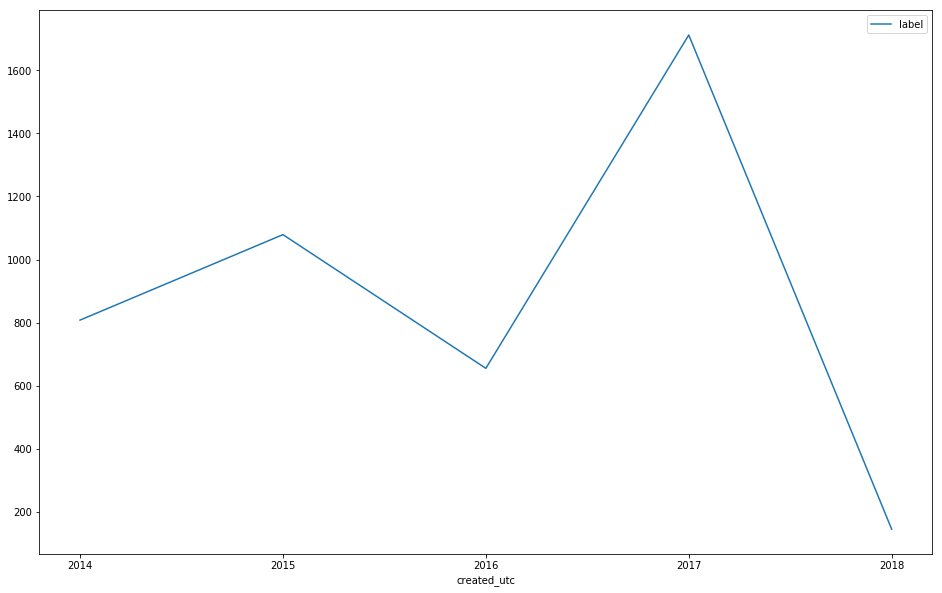

In [35]:
labelplot.plot(x='created_utc',y='label', figsize = (16,10));

[]

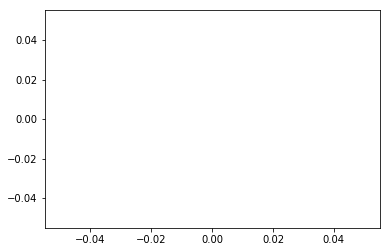

In [28]:
plt.plot(x=DBdf.created_utc.dt.year, y=DBdf.label.count())

In [25]:
countlabels_df = DBdf.groupby('label').count()
db_plotdf.head()

,0,1,2,3,4,created_utc
label,,,,,,
0,3376,3376,3376,3376,3376,3376
1,405,405,405,405,405,405
2,71,71,71,71,71,71
3,110,110,110,110,110,110
4,123,123,123,123,123,123


In [14]:
DBdf_group = DBdf.groupby(by=[pd.Grouper(key='created_utc',freq='Y')]).mean()
DBdf_group.head(2)

,0,1,2,3,4,label
created_utc,,,,,,
2014-12-31,0.193090,0.171964,0.237001,0.199405,0.198541,0.784653
2015-12-31,0.205043,0.181192,0.217073,0.218702,0.177990,0.612604


In [9]:
DBdf_group.plot(x='label', figsize=(16,12))

ValueError: view limit minimum -36770.688677577826 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f86ac341d90> (for post_execute):


ValueError: view limit minimum -36770.688677577826 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36770.688677577826 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [150]:
transformed_lda[0]

array([0.04059063, 0.04077981, 0.04043575, 0.83730984, 0.04088397])

In [151]:
db.core_sample_indices_

array([   0,    1,    2, ..., 4997, 4998, 4999])

In [148]:
db.core_sample_indices_.shape

(4942,)

In [91]:
# Create DataFrame of documents by topic and add in timestamp for document
lda_df = pd.DataFrame(data=transformed_lda, copy=True)
df2 = df.reset_index()
# lda_df = lda_df.join(df.created_utc)
lda_df['created_utc'] = df2['created_utc']

In [92]:
dfgrouped = lda_df.groupby(by=[pd.Grouper(key='created_utc',freq='Y')]).mean().reset_index()
dfgrouped.head(3)

,created_utc,0,1,2,3,4
0,2011-12-31,0.192425,0.137565,0.241323,0.244446,0.184241
1,2012-12-31,0.216035,0.158908,0.235008,0.208248,0.181802
2,2013-12-31,0.209730,0.182087,0.212661,0.200342,0.195180


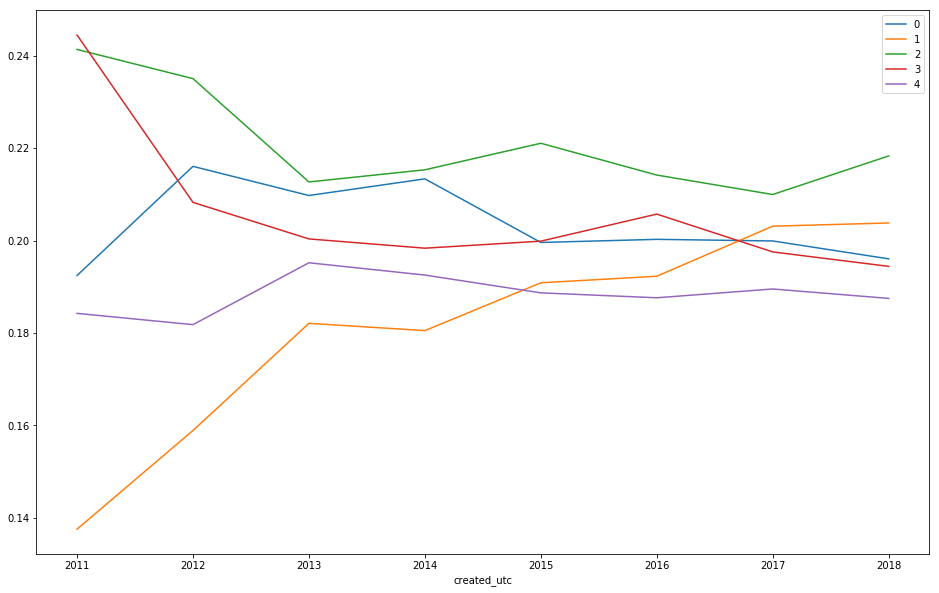

In [93]:
dfgrouped.plot(x='created_utc', figsize = (16,10));

In [222]:
# # Save to do a hard-clustering algo like kmeans for later
# transformed_lda[0]
# transformed_lda[1]
# transformed_lda.argmax(axis=1)
# km = KMeans(n_clusters=5, init='k-means++', random_state=0, n_jobs=-1)
# topic_split = km.fit_transform(transformed_lda)
# topic_split[0]
# topic_split[2]
# topic_split.shape

In [ ]:
transformed_lda

In [65]:
pd.DataFrame(dtm_tf_custom.toarray(), columns=cVectorizer.get_feature_names()).shape

lda_tf = LatentDirichletAllocation(n_components=15, random_state=0)
lda_tf.fit(dtm_tf_custom)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf_custom, cVectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.050456  0.068146       1        1  12.343966
6     -0.015559  0.076990       2        1   8.541368
9      0.015332  0.020617       3        1   7.716463
0     -0.086664 -0.041103       4        1   6.896758
11     0.097437  0.032138       5        1   6.744538
8      0.061580  0.017532       6        1   6.402759
1     -0.060601  0.001668       7        1   6.174580
7      0.122422  0.037775       8        1   6.080679
10    -0.030208  0.082661       9        1   6.030568
12     0.100708  0.081865      10        1   6.006607
14    -0.059938 -0.175645      11        1   5.881264
4     -0.145948  0.054876      12        1   5.717746
2     -0.161351 -0.031329      13        1   5.441466
13     0.122482 -0.024180      14        1   5.425373
3      0.090765 -0.202013      15        1   4.595865, topic_info=      Category         Freq      Term        Total  loglift  logprob
term                                                                
12406  Default  1374.000000      year  1374.000000  30.0000  30.0000
9102   Default  1149.000000    season  1149.000000  29.0000  29.0000
10514  Default  1931.000000      team  1931.000000  28.0000  28.0000
7060   Default  2025.000000       one  2025.000000  27.0000  27.0000
4108   Default  1102.000000       got  1102.000000  26.0000  26.0000
4504   Default   426.000000    harden   426.000000  25.0000  25.0000
11653  Default   642.000000      wade   642.000000  24.0000  24.0000
3991   Default  1278.000000      good  1278.000000  23.0000  23.0000
12148  Default  1014.000000       win  1014.000000  22.0000  22.0000
11804  Default   785.000000     watch   785.000000  21.0000  21.0000
1040   Default  1035.000000    better  1035.000000  20.0000  20.0000
7785   Default  1393.000000    player  1393.000000  19.0000  19.0000
2684   Default   263.000000     doubl   263.000000  18.0000  18.0000
9240   Default   340.000000      seen   340.000000  17.0000  17.0000
7547   Default   305.000000       per   305.000000  16.0000  16.0000
619    Default  1041.000000      back  1041.000000  15.0000  15.0000
11140  Default   552.000000       top   552.000000  14.0000  14.0000
3945   Default   322.000000      goat   322.000000  13.0000  13.0000
4668   Default   434.000000      high   434.000000  12.0000  12.0000
10014  Default  1136.000000     still  1136.000000  11.0000  11.0000
2228   Default   440.000000     curri   440.000000  10.0000  10.0000
4216   Default   944.000000     great   944.000000   9.0000   9.0000
5114   Default   733.000000    jordan   733.000000   8.0000   8.0000
1286   Default   282.000000      bosh   282.000000   7.0000   7.0000
11304  Default   214.000000     tripl   214.000000   6.0000   6.0000
3535   Default   810.000000     first   810.000000   5.0000   5.0000
1737   Default   395.000000     coach   395.000000   4.0000   4.0000
8658   Default   204.000000   regular   204.000000   3.0000   3.0000
3083   Default   773.000000      ever   773.000000   2.0000   2.0000
10931  Default  1854.000000      time  1854.000000   1.0000   1.0000
...        ...          ...       ...          ...      ...      ...
1299   Topic15    68.968201    boston   120.344042   2.5233  -5.1226
6415   Topic15    71.901881      mike   128.300567   2.5009  -5.0810
883    Topic15   110.438995      beat   255.905815   2.2397  -4.6518
1401   Topic15    25.148227      burn    34.674733   2.7588  -6.1315
9976   Topic15    76.028340      stay   176.609502   2.2372  -5.0252
8422   Topic15    51.753893       ray   100.993175   2.4115  -5.4098
11708  Topic15    92.076144      wait   286.866408   1.9436  -4.8337
6653   Topic15    59.716004      name   146.620901   2.1818  -5.2667
11098  Topic15    68.901883     today   198.414388   2.0223  -5.1236
11744  Topic15   115.385070      want   606.731262   1.4202  -4.6080
4425   Topic15    32.509028    hakeem    56.630656   2.5250  -5.8748
113

:::::
Number of topics = 6
:::::
TOPIC 0
season
one
player
best
got
time
better
man
year
career

TOPIC 1
back
team
time
peopl
one
want
know
doubl
right
ball

TOPIC 2
love
pretti
shot
ever
damn
good
seen
first
one
wade

TOPIC 3
play
watch
could
day
love
got
defens
good
imagin
actual

TOPIC 4
team
could
need
make
harden
ball
pick
time
give
still

TOPIC 5
year
time
realli
still
jordan
everi
peopl
win
never
man

:::::
Number of topics = 7
:::::
TOPIC 0
player
one
best
season
better
got
time
watch
man
top

TOPIC 1
one
back
know
team
doubl
nice
time
big
want
right

TOPIC 2
pretti
love
shot
ever
lanc
seen
thing
damn
point
one

TOPIC 3
play
defens
day
ball
good
actual
got
love
still
holi

TOPIC 4
team
could
harden
make
coach
first
one
pick
still
time

TOPIC 5
year
time
still
jordan
man
one
realli
tri
peopl
anyon

TOPIC 6
last
team
realli
year
come
wade
back
love
win
could

:::::
Number of topics = 8
:::::
TOPIC 0
season
one
time
got
better
man
player
year
watch
much

TOPIC 1
back
know
one
doub

In [33]:
cv = CountVectorizer(stop_words=stops, 
                     #analyzer=english_corpus,
                     analyzer=analyzer,
                     min_df = 3, max_df = .95, ngram_range=(1, 2),
                     strip_accents='unicode', 
                     encoding='utf-8',
                     # tokenizer=TreebankWordTokenizer().tokenize,
                     #max_features=100
                    )

In [33]:
dtm_tf = cv.fit_transform(df_small_train.body)
dtm_tf.shape

(14000, 5298)

# LDA

In [34]:
# pd.DataFrame(dtm_tf.toarray(), columns=cv.get_feature_names()).shape

# lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
# lda_tf.fit(dtm_tf)

# # pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, cv)


# see_lda_topics(cv, 5, lda_tf, 7)

for n_topic in range(3,10):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
    loop_lda_tf.fit(dtm_tf)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cv, n_topic, loop_lda_tf, 7)

KeyboardInterrupt: 

# TF-IDF

In [71]:
cv2 = CountVectorizer(#stop_words=stops, 
                     analyzer=english_corpus, 
                     min_df = 2, max_df = .95, #ngram_range=(1, 2),
                     strip_accents='unicode', encoding='utf-8')

tfidf_vectorizer = TfidfVectorizer(**cv2.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_small_train.body)

lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.051493 -0.005656       1        1  17.891667
7     -0.068342  0.014101       2        1  13.069484
5     -0.035743 -0.013699       3        1   9.888963
4     -0.070377 -0.058975       4        1   9.431428
1     -0.082874 -0.050363       5        1   9.166373
6      0.089967  0.041093       6        1   8.382241
3     -0.002557  0.129411       7        1   8.372704
2      0.082768  0.092074       8        1   8.316884
9     -0.001495 -0.011377       9        1   8.013487
8      0.140146 -0.136609      10        1   7.466769, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1510  Default  34.000000      nice  34.000000  30.0000  30.0000
491   Default  33.000000   confirm  33.000000  29.0000  29.0000
593   Default  46.000000      damn  46.000000  28.0000  28.0000
696   Default  22.000000     doubl  22.000000  27.0000  27.0000
1261  Default  20.000000      king  20.000000  26.0000  26.0000
1458  Default  18.000000      miss  18.000000  25.0000  25.0000
1390  Default  65.000000       man  65.000000  24.0000  24.0000
2403  Default  16.000000     tripl  16.000000  23.0000  23.0000
1382  Default  24.000000     magic  24.000000  22.0000  22.0000
1897  Default  42.000000     right  42.000000  21.0000  21.0000
1552  Default  20.000000        oh  20.000000  20.0000  20.0000
1010  Default  26.000000       god  26.000000  19.0000  19.0000
2331  Default  14.000000       tho  14.000000  18.0000  18.0000
1367  Default  65.000000      love  65.000000  17.0000  17.0000
1446  Default  15.000000   million  15.000000  16.0000  16.0000
1985  Default  54.000000    season  54.000000  15.0000  15.0000
1781  Default  18.000000  question  18.000000  14.0000  14.0000
1842  Default  15.000000   regular  15.000000  13.0000  13.0000
1045  Default  43.000000       guy  43.000000  12.0000  12.0000
2382  Default  15.000000     trade  15.000000  11.0000  11.0000
445   Default  25.000000     coach  25.000000  10.0000  10.0000
1614  Default  27.000000      pass  27.000000   9.0000   9.0000
1830  Default  14.000000    record  14.000000   8.0000   8.0000
1875  Default  16.000000   respect  16.000000   7.0000   7.0000
336   Default  28.000000      call  28.000000   6.0000   6.0000
1415  Default  24.000000      mean  24.000000   5.0000   5.0000
103   Default  23.000000     anyon  23.000000   4.0000   4.0000
1278  Default  17.000000      lanc  17.000000   3.0000   3.0000
2358  Default  15.000000     today  15.000000   2.0000   2.0000
28    Default  11.000000        ad  11.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
136   Topic10   1.836326  assassin   2.601165   2.2465  -6.4022
1401  Topic10   1.772000    martin   2.536830   2.2359  -6.4379
1462  Topic10   2.239007        mo   3.221734   2.2308  -6.2040
1515  Topic10   6.359971    nobodi   9.640802   2.1787  -5.1600
1875  Topic10  10.100956   respect  16.101310   2.1284  -4.6974
2550  Topic10   5.587835      west   8.584732   2.1653  -5.2894
736   Topic10   3.532103     earth   5.281132   2.1925  -5.7481
1252  Topic10   3.969750       kat   6.067462   2.1705  -5.6313
1278  Topic10   9.606736      lanc  17.530202   1.9932  -4.7475
103   Topic10  11.903119     anyon  23.768682   1.9031  -4.5332
2250  Topic10   6.523186     super  12.347907   1.9566  -5.1346
2522  Topic10   3.774530      wall   6.325863   2.0783  -5.6817
212   Topic10   5.995098    behind  12.764355   1.8390  -5.2191
1312  Topic10   4.452740     legit   8.572849   1.9396  -5.5165
2258  Topic10   4.457640   surpris   8.655915   1.9311  -5.5154
1266  Topic10  10.888165      know  47.357496   1.1247  -4.6223
740   Topic10   4.665654    easili   9.482974   1.8854  -5.4698
1110  Topic10   4.447925      hold   9.409466   1.8454  -5.5176
765   Topic10   5.365001       els  17.279312

In [23]:
cv.get_feature_names()

['abil',
 'abl',
 'about',
 'abov',
 'absolut',
 'absorb',
 'absurd',
 'abus',
 'accept',
 'accomplish',
 'accord',
 'achiev',
 'across',
 'act',
 'activ',
 'actor',
 'actual',
 'ad',
 'add',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advic',
 'advoc',
 'after',
 'again',
 'against',
 'age',
 'agenc',
 'agent',
 'aggress',
 'ago',
 'agre',
 'ah',
 'ahead',
 'ai',
 'aint',
 'air',
 'albeit',
 'alien',
 'all',
 'alley',
 'almost',
 'alon',
 'along',
 'alongsid',
 'alreadi',
 'also',
 'altern',
 'alway',
 'am',
 'amaz',
 'ami',
 'among',
 'amongst',
 'amount',
 'an',
 'analysi',
 'analyst',
 'and',
 'angl',
 'angri',
 'ani',
 'anim',
 'ankl',
 'annoy',
 'annual',
 'anonym',
 'anoth',
 'answer',
 'anti',
 'anybodi',
 'anyon',
 'anyth',
 'anyway',
 'anywher',
 'apart',
 'appear',
 'appl',
 'appreci',
 'appropri',
 'are',
 'arena',
 'argu',
 'argument',
 'arm',
 'around',
 'art',
 'articl',
 'as',
 'asham',
 'asid',
 'ask',
 'aspect',
 'ass',
 'assassin',
 'assist',
 'assum'

In [25]:
cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(sentences[:500])
Z = pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

In [26]:
Z.shape

(500, 1790)

In [27]:
cv2 = CountVectorizer(stop_words='english')
XX = cv2.fit_transform(words[:500])
Z = pd.DataFrame(XX.toarray(),columns=cv2.get_feature_names())

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(stop_words='english')
X3 = tf.fit_transform(sentences[:500])
Z = pd.DataFrame(X3.toarray(), columns = tf.get_feature_names())

In [34]:
Z.shape

(500, 1790)

In [18]:
from nltk import sent_tokenize
text = df.body.apply(sent_tokenize)
text.sample(3, random_state=42)

25798    [As much hate as this dude gets, their is no denying that he can ball, and he's breaking these records at a relative...
26644                [The last 9 finals have consisted of either LeBron James Jones or Kobe Bryant, but never at the same time.]
5307                                                                                                        [That's just unfair]
Name: body, dtype: object

In [19]:
from nltk import word_tokenize
words = df.body.apply(word_tokenize)
words.sample(3, random_state=42)    

25798    [As, much, hate, as, this, dude, gets, ,, their, is, no, denying, that, he, can, ball, ,, and, he, 's, breaking, the...
26644    [The, last, 9, finals, have, consisted, of, either, LeBron, James, Jones, or, Kobe, Bryant, ,, but, never, at, the, ...
5307                                                                                                    [That, 's, just, unfair]
Name: body, dtype: object

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(df.body[90:100])
pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

,16,added,ago,akron,april,believe,better,chugging,come,considered,...,retired,retires,rose,said,smhhhh,teenager,think,wait,workaholic,years
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df = joblib.load('data/clean/clean_df.joblib')

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()

In [21]:
prob_selected = 2/16
num_trial = 27

In [26]:
# probability of num of trials up to and until 1st success
P = ((1-prob_selected)**(num_trial-1)) * prob_selected
P * 100

0.3882570868012486

In [25]:
# probability of num of failures until 1st success
P2 = ((1-prob_selected)**(num_trial)) * prob_selected
P2 * 100

0.33972495095109256